In [1]:
import random

from finrl.meta.env_portfolio_allocation import env_portfolio
import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange

In [2]:
############STUFF GRABBED FROM FINRL TUTORIAL
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys

## 2.4. Create Folders
import os

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

df.head()
df.shape

/Users/scott/opt/anaconda3/envs/FinRL/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

(101615, 8)

In [3]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)
df.shape
df.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,5.898639,1079178800,AAPL,2,0.0,5.903858,5.896147,100.0,-66.666667,100.0,5.898639,5.898639
3483,2008-01-02,46.599998,47.040001,46.259998,33.761421,7934400,AMGN,2,0.0,5.903858,5.896147,100.0,-66.666667,100.0,33.761421,33.761421
6966,2008-01-02,52.090000,52.320000,50.790001,39.588001,8053700,AXP,2,0.0,5.903858,5.896147,100.0,-66.666667,100.0,39.588001,39.588001
10449,2008-01-02,87.570000,87.839996,86.000000,63.481617,4303000,BA,2,0.0,5.903858,5.896147,100.0,-66.666667,100.0,63.481617,63.481617
13932,2008-01-02,72.559998,72.669998,70.050003,45.605484,6337800,CAT,2,0.0,5.903858,5.896147,100.0,-66.666667,100.0,45.605484,45.605484


In [4]:
df.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
83591,2021-10-29,162.130005,162.440002,160.660004,153.936401,1314100,TRV,4,1.424914,156.635665,144.752577,55.691982,130.838278,19.622993,149.630913,150.155368
87074,2021-10-29,454.410004,461.390015,453.059998,446.448090,2497800,UNH,4,12.768889,458.350879,365.485245,67.009719,145.342648,52.064871,405.058988,404.183500
90557,2021-10-29,52.500000,53.049999,52.410000,46.802307,17763200,VZ,4,-0.170569,48.086329,45.189775,46.685009,-39.966408,12.569826,46.875142,47.474614
94040,2021-10-29,46.860001,47.279999,46.770000,41.523605,4999000,WBA,4,-0.169815,44.202654,40.524219,45.913462,-97.394877,0.268701,42.391107,42.889372
97523,2021-10-29,147.910004,150.100006,147.559998,144.852417,7340900,WMT,4,1.795641,147.887258,129.205260,59.710649,130.750293,35.423702,138.057023,140.642313


In [5]:
## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583910,607541200,AAPL,2,-0.082603,3.093652,2.454291,42.254789,-80.462511,16.129793,2.749560,2.861671,"[[0.0013489692418775557, 0.0004284139989242508...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839535,6287200,AMGN,2,0.156758,42.707023,40.853199,51.060642,51.523672,10.432018,41.058033,40.603775,"[[0.0013489692418775557, 0.0004284139989242508...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580750,9625600,AXP,2,-0.935583,18.646867,12.660477,42.554828,-75.437694,25.776759,15.744065,17.616374,"[[0.0013489692418775557, 0.0004284139989242508...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005890,5443100,BA,2,-0.279801,32.174381,28.867833,47.440243,156.994917,5.366299,30.327211,32.389914,"[[0.0013489692418775557, 0.0004284139989242508...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608652,6277400,CAT,2,0.655611,30.348091,25.455647,51.205303,98.374108,26.331746,26.689551,26.423592,"[[0.0013489692418775557, 0.0004284139989242508...",tic AAPL AMGN AXP ...


In [6]:
## Training data split: 2009-01-01 to 2020-07-01
train = data_split(df, '2009-01-01', '2020-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,2.747390,746015200,AAPL,4,-0.070153,3.080129,2.452222,45.440187,-32.212994,2.140064,2.750408,2.862473,"[[0.0013661507161541254, 0.0004339394370086589...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,42.737892,6547900,AMGN,4,0.232163,42.852617,40.817726,52.756855,92.828031,0.814217,41.122029,40.691921,"[[0.0013661507161541254, 0.0004339394370086589...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,15.193848,10955700,AXP,4,-0.832049,18.463254,12.644441,43.957537,-42.853088,16.335101,15.742755,17.499519,"[[0.0013661507161541254, 0.0004339394370086589...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4,-0.002009,32.948625,28.452125,50.822040,272.813028,20.494464,30.469477,32.344130,"[[0.0013661507161541254, 0.0004339394370086589...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,31.093395,7117200,CAT,4,0.833183,30.850187,25.434766,53.661247,129.524653,34.637448,26.926402,26.424173,"[[0.0013661507161541254, 0.0004339394370086589...",tic AAPL AMGN AXP ...


In [7]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym_random = StockPortfolioEnv(df = train, **env_kwargs)
e_train_gym_single_stock_nstep_sarsa = StockPortfolioEnv(df = train, **env_kwargs)

Stock Dimension: 28, State Space: 28


In [8]:
import random
def random_agent(env: StockPortfolioEnv):
    env.reset()
    terminal = False
    while not terminal:
        action = [0] * len(env.action_space.sample())
        action[random.randint(0,  len(env.action_space.sample()) - 1)] = 1
        state, reward, terminal, _, _ = env.step(action)
    return env

In [9]:
env_rand_post_training = random_agent(e_train_gym_random)

begin_total_asset:1000000
end_total_asset:5903444.101724851
Sharpe:  0.9379218356006198


In [10]:
from agents.single_stock_tabular import nstep_sarsa_single_stock

In [11]:
env_nstep_sarsa_post_training, episodes, _ = nstep_sarsa_single_stock(e_train_gym_single_stock_nstep_sarsa, num_episodes=5, gamma=0.99, epsilon=0.1, step_size=0.5, n=40, stock=0)

Episode:   0%|          | 0/5 [00:00<?, ?it/s]

Episode:  20%|██        | 1/5 [00:03<00:14,  3.56s/it]

begin_total_asset:1000000
end_total_asset:6255223.506060048
Sharpe:  0.9673927897720405


Episode:  40%|████      | 2/5 [00:07<00:10,  3.57s/it]

begin_total_asset:1000000
end_total_asset:6296073.013116989
Sharpe:  0.969955838351546


Episode:  60%|██████    | 3/5 [00:10<00:07,  3.53s/it]

begin_total_asset:1000000
end_total_asset:6288529.529650994
Sharpe:  0.9703507899959317


Episode:  80%|████████  | 4/5 [00:14<00:03,  3.56s/it]

begin_total_asset:1000000
end_total_asset:6264336.18624744
Sharpe:  0.9680922578919282


begin_total_asset:1000000
end_total_asset:6319972.590799077
Sharpe:  0.972258290054779


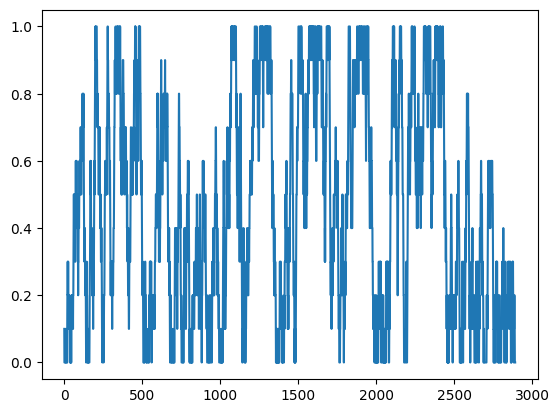

In [12]:
percent = [e[3] for e in episodes[0]]
plt.plot(list(range(len(percent))), percent)

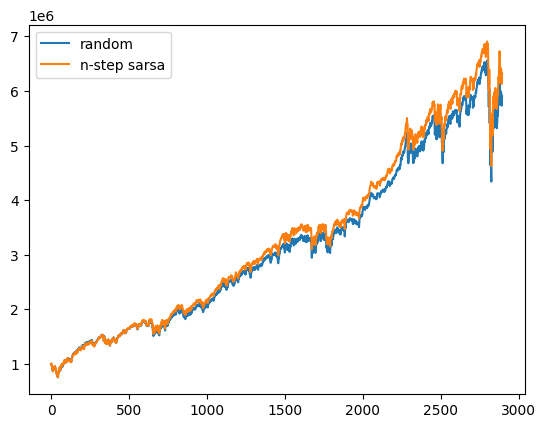

In [13]:
plt.plot(list(range(len(env_rand_post_training.portfolio_return_memory

))), env_rand_post_training.asset_memory, label="random"
)
plt.plot(list(range(len(env_nstep_sarsa_post_training.portfolio_return_memory

))), env_nstep_sarsa_post_training.asset_memory, label="n-step sarsa"

)
plt.legend()
plt.show()

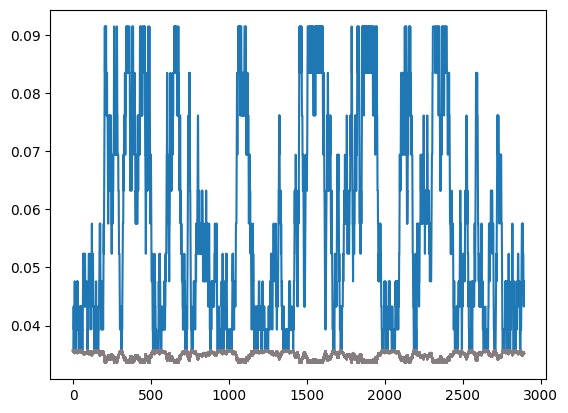

In [14]:
plt.plot(env_nstep_sarsa_post_training.actions_memory)